In [1]:
from IPython.display import Audio
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import numpy as np
from scipy.signal import butter,filtfilt, lfilter
from scipy.io import wavfile


In [2]:
def plot_spec(sign):
    D = librosa.stft(sign, n_fft=2048) 
    print(D.shape)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    #print(S_db.shape)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()

(1025, 112)


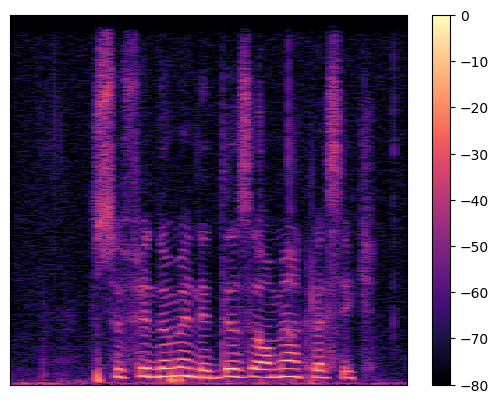

In [3]:
ya, sr = librosa.load('/home/alessandrab/python_files/clean_air_train/output_222.wav')
plot_spec(ya)

In [4]:
sr

22050

In [5]:
Audio(ya, rate=sr)

(1025, 112)


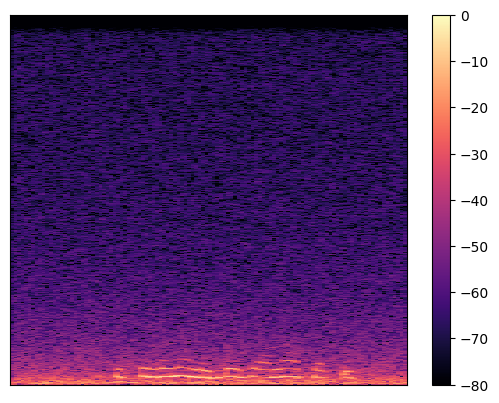

In [6]:
yb, sr = librosa.load('/home/alessandrab/python_files/clean_bone_train/output_222.wav')
plot_spec(yb)

In [7]:
Audio(yb, rate=sr)

In [8]:
#flters used to reproduce the bone conduction signal from the air conduction one



def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
def butter_bandpass(lowcut, highcut, fs, order=5):

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# bone conduction filter 

def bone_conduction_filter(air_conduction_signal, sample_rate):
    
    bone_conduction_signal = butter_lowpass_filter(air_conduction_signal, 600, sample_rate, order=2)
    cutoff_freq = 30 #150
    order = 4 
    nyq = 0.5 * sample_rate

    normal_cutoff = cutoff_freq / nyq

    b, a = butter(order, normal_cutoff, btype='highpass')  #to ehnance voice over noise
    bone_conduction_signal = filtfilt(b, a, bone_conduction_signal)

    #create noise, this noise in natural bone conduction audio is present due to the natural friction of the headphones against the user's skin
    power = 0.00001 
    duration = len(bone_conduction_signal) 
    noise = np.random.normal(0, np.sqrt(power), duration)


    
    bone_conduction_signal = butter_bandpass_filter(bone_conduction_signal, 0.3, 2.5, sample_rate, order=1)

    noise = butter_bandpass_filter(noise, 0.1, 1, sample_rate, order=1)
    noise = filtfilt(b, a,noise)

    
    bone_conduction_signal =  bone_conduction_signal + noise
    bone_conduction_signal = np.float32(bone_conduction_signal)
    
    #amplify signal
    db_increase = 60.0
    amplification_factor = 10 ** (db_increase / 20)
    bone_conduction_signal = bone_conduction_signal * amplification_factor
    return bone_conduction_signal


In [9]:
yc = bone_conduction_filter(ya, sr)

In [10]:
Audio(yc, rate=sr)

(1025, 112)


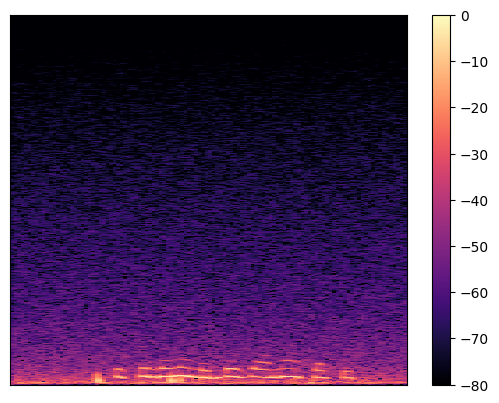

In [11]:
plot_spec(yc)

In [12]:
#Write two files: one with the real bone conduction audio and one with the audio recreated by the filter

wavfile.write('bone_cond.wav', rate=sr, data=np.float32(yc))
wavfile.write('real_bone_cond.wav', rate=sr, data=yb)

In [13]:
frequencies = librosa.fft_frequencies(sr=sr, n_fft=1024)
def spectrogram(waveform, frame_size=1024, hop_size=512):
    window = np.hanning(frame_size)
    # Calculate the STFT using the Hann window
    stft_audio =librosa.stft(waveform, n_fft=frame_size, hop_length=hop_size, window=window)
    spectr = np.abs(stft_audio)  # Magnitude spectrogram
    
    return spectr
def plot_avg_spec(avg_db, frequencies):
    plt.figure(figsize=(12, 8))
    plt.plot(frequencies, avg_db, color='blue')
    #style
    plt.xscale('log')
    plt.yscale('log')
    plt.fill_between(frequencies, avg_db)
   
    plt.grid(True, which='both', linestyle='--', lw=0.5)
    plt.ylim(min(avg_db),max(avg_db))
    #title
    plt.title('Magnitude Spectrum (dB)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')


    plt.show()

In [14]:
bone_specrt = spectrogram(yc)
real_bone = spectrogram(yb)
averages_yc = [np.mean(arr, axis=0) for arr in bone_specrt]
averages_yb =[np.mean(arr, axis=0) for arr in real_bone]

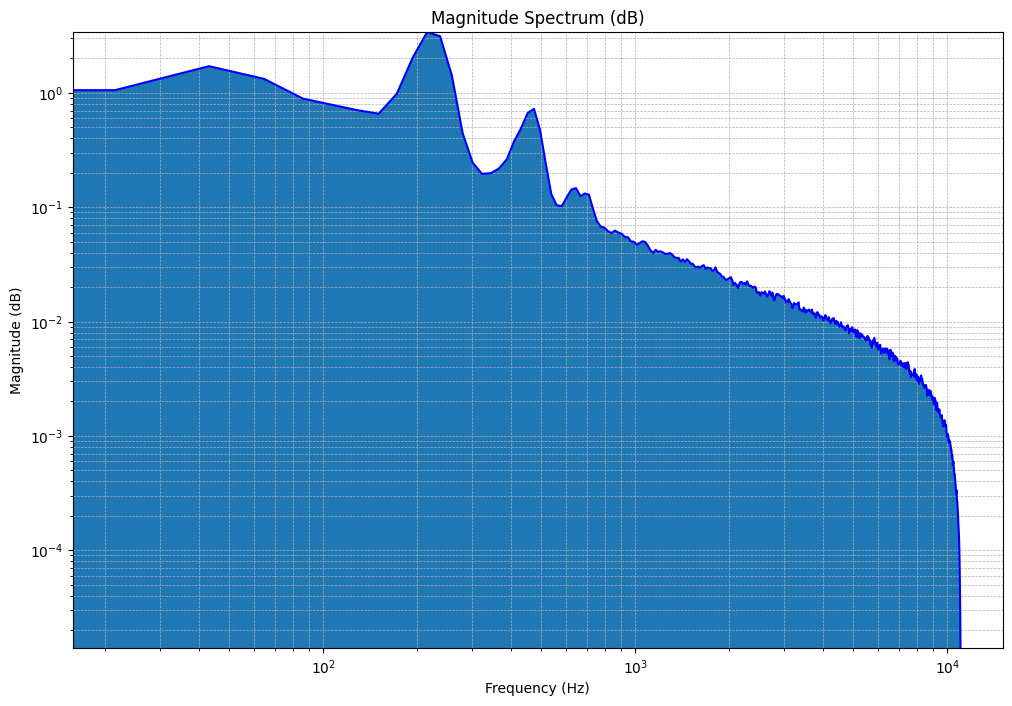

In [15]:
plot_avg_spec(averages_yc,frequencies)

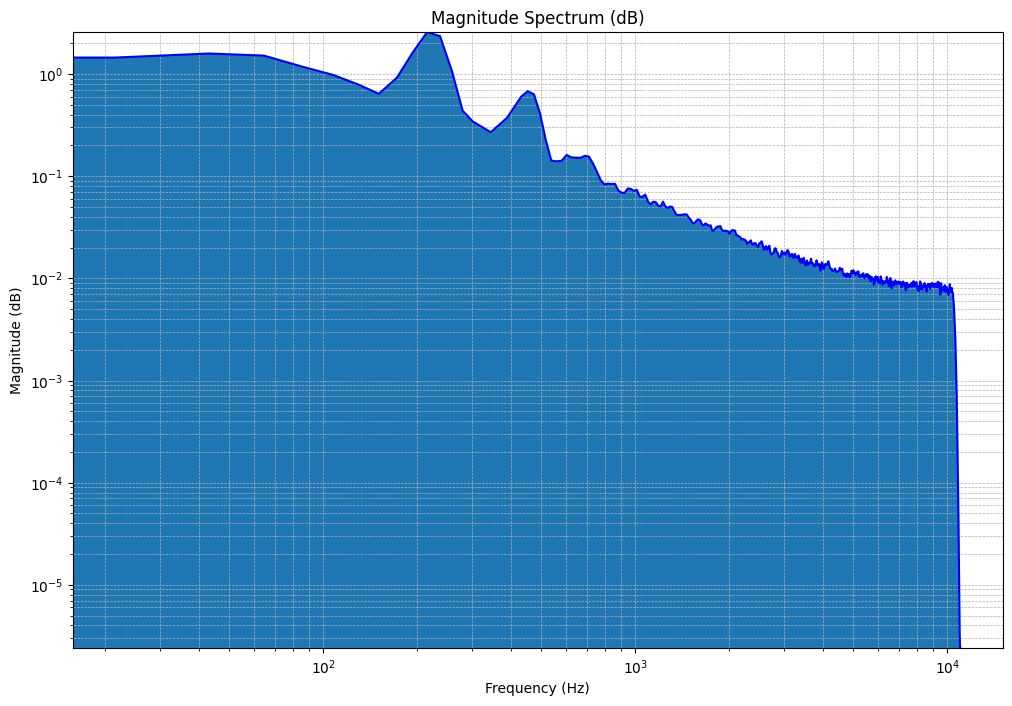

In [16]:
plot_avg_spec(averages_yb,frequencies)